<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>


<h6><center>Machine Learning Project</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Face Recognition on LFW</center>
<hr style=" border:none; height:3px;">
</h1>

In [ ]:
from time import time
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.datasets import fetch_lfw_people

from statistics import mean


# Data Extraction


Le dataset utilisé est Labelled Faces in the Wild. Il est disponible à https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html. 



In [ ]:


dataset = fetch_lfw_people()

## Exercice 1 - Exploration des données



In [ ]:
#Nan exploration

features = pd.DataFrame(dataset.data)
target = pd.DataFrame(dataset.target)


print( "Info on features set \n ------------------ \n")
print(features.info())

print( "\n Info on target set \n ------------------ \n")
print(target.info())

Info on features set 
 ------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13233 entries, 0 to 13232
Columns: 2914 entries, 0 to 2913
dtypes: float32(2914)
memory usage: 147.1 MB
None

 Info on target set 
 ------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13233 entries, 0 to 13232
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       13233 non-null  int64
dtypes: int64(1)
memory usage: 103.5 KB
None


### Features dataset


Chaque image de visage est représentée par un vecteur de 2914 pixels (62*47) en niveaux de gris.

D'après _features.info()_, il n'y a pas de __NaNs__ dans le dataset.


In [ ]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,34.000000,29.333334,22.333334,22.000000,25.666666,29.000000,38.666668,68.333336,96.333336,116.666664,131.666672,140.333328,143.666672,148.666672,153.333328,155.666672,158.333328,163.333328,166.333328,164.333328,165.000000,167.000000,165.333328,160.333328,164.666672,167.000000,164.000000,160.000000,156.333328,153.000000,152.666672,150.666672,144.000000,133.333328,126.333336,123.333336,115.333336,102.666664,88.000000,78.000000,...,19.000000,15.666667,13.000000,13.666667,16.000000,19.000000,20.333334,28.666666,50.000000,67.666664,83.000000,104.000000,116.666664,121.000000,123.333336,124.000000,117.333336,111.333336,107.000000,100.666664,92.333336,93.666664,96.666664,96.666664,86.666664,65.666664,62.000000,65.000000,57.333332,42.000000,26.666666,17.333334,11.000000,8.000000,4.333333,5.666667,11.333333,14.666667,16.000000,14.000000
1,158.000000,160.666672,169.666672,168.333328,162.666672,161.000000,158.333328,162.666672,163.000000,159.000000,159.000000,170.000000,173.000000,162.666672,164.000000,166.333328,166.333328,156.666672,147.666672,140.000000,137.666672,137.333328,135.000000,133.666672,134.333328,136.000000,134.666672,135.000000,133.666672,129.333328,122.666664,115.333336,110.333336,108.333336,108.333336,116.333336,124.666664,134.666672,148.000000,162.000000,...,218.666672,222.333328,193.000000,144.333328,115.000000,107.000000,108.333336,112.666664,117.666664,119.666664,117.333336,110.333336,107.666664,108.666664,105.666664,104.000000,105.333336,107.666664,109.333336,112.333336,112.333336,112.000000,111.000000,107.666664,104.333336,100.333336,95.333336,94.666664,109.666664,183.666672,217.666672,198.666672,169.000000,122.000000,106.333336,117.666664,133.000000,138.666672,135.333328,130.333328
2,77.000000,81.333336,88.000000,108.666664,136.000000,151.333328,155.000000,164.666672,168.000000,172.000000,175.333328,173.666672,175.666672,180.333328,185.000000,187.666672,188.333328,188.666672,190.333328,190.666672,190.333328,191.666672,193.000000,193.333328,192.000000,191.000000,190.333328,191.333328,189.000000,186.000000,187.000000,187.333328,186.333328,183.000000,175.666672,169.333328,161.333328,149.000000,146.000000,127.333336,...,154.000000,211.000000,182.666672,150.000000,132.666672,99.666664,75.000000,68.666664,78.000000,92.666664,105.333336,110.666664,113.333336,117.333336,121.000000,124.333336,125.333336,128.666672,130.666672,132.333328,132.666672,134.000000,132.666672,131.666672,119.666664,94.333336,76.000000,85.333336,131.666672,168.333328,177.666672,190.666672,219.333328,227.000000,218.666672,210.666672,202.000000,192.000000,145.333328,66.333336
3,11.333333,11.333333,11.666667,12.666667,13.666667,15.000000,15.000000,13.000000,13.000000,14.000000,14.333333,13.333333,12.666667,10.666667,9.666667,13.000000,14.333333,11.333333,12.333333,15.333333,13.000000,11.666667,13.333333,14.333333,14.333333,16.000000,17.333334,18.000000,17.000000,17.000000,18.333334,19.666666,21.666666,22.000000,23.000000,23.333334,21.333334,19.000000,18.333334,23.000000,...,60.666668,77.000000,77.333336,76.333336,71.333336,63.666668,58.666668,59.666668,67.666664,80.666664,92.666664,96.000000,97.333336,98.333336,100.000000,101.333336,100.333336,98.000000,99.666664,102.333336,103.333336,103.000000,99.333336,93.333336,86.333336,78.666664,75.000000,83.333336,101.666664,117.000000,121.333336,123.333336,124.000000,121.000000,118.333336,120.666664,123.000000,118.000000,106.333336,92.333336
4,32.333332,31.333334,31.333334,33.666668,33.000000,32.333332,36.333332,43.333332,43.000000,36.000000,26.333334,23.000000,24.333334,25.333334,30.000000,33.666668,30.000000,26.000000,30.000000,37.000000,44.333332,50.333332,58.333332,66.333336,74.000000,79.666664,78

Ici, on peut voir que tous les pixels sont homogènes avec des __valeurs comprises entre 0 et 255__ (cf _Overall Minimum et Overall Maximum_ ci-dessous). 

En regardant les distributions de chaques pixel, (cf _features.describe()_ ci-dessous), on s'aperçoit que la __variabilité__ du dataset est assez __importante__. On a par example une moyenne de 74 pour le premier pixel et de 162 pour le 23<sup>ème</sup> et des variations importantes d'écarts-types. On comprends notamment que __les pixels au milieu du visage devront être capté avec une attention particulière__ (notamment par PCA) et le fond attenué, pour fournir un bon prédicteur.

En outre, une __Analyse en Composantes Principales__, semble nécessaire pour réduire la dimension du dataset en entrée d'un prédicteur et ainsi atténuer le __risque d'overfitting__.


In [ ]:
print("Overall maximum : ", features.max().max())
print("Overall minimum : ", features.min().min())

features.describe()

Overall maximum :  255.0
Overall minimum :  0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
count,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,...,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000
mean,73.645020,76.609215,82.047195,89.338463,97.436172,105.404922,113.072159,120.380386,127.049438,132.753311,137.819595,142.331421,146.231857,149.469559,152.144867,154.359192,156.254944,157.818695,159.200699,160.345352,161.270996,162.002487,162.425323,162.655182,162.691071,162.333450,161.849945,161.238342,160.271118,158.981750,157.344467,155.281403,152.792831,149.865860,146.369812,142.240189,137.435410,131.933029,125.591309,118.418243,...,104.424706,104.075333,102.479645,100.350830,98.099464,96.020126,94.033875,92.549194,92.015480,92.470276,93.428322,94.867668,96.414398,97.750824,98.777374,99.491516,99.865074,99.877296,99.525955,98.900841,97.823929,96.372055,94.763443,93.053596,91.621933,90.674675,90.379761,91.263000,93.349892,96.472878,100.214882,104.268295,107.929878,110.543449,111.502693,110.941605,109.213936,106.370956,102.723381,99.468056
std,50.931728,50.792950,51.222122,52.013630,52.721523,53.071274,52.734890,51.895874,50.904091,49.955223,49.015141,48.178173,47.401062,46.733219,46.190147,45.782391,45.481377,45.199875,44.951317,44.742310,44.626316,44.568790,44.503929,44.304459,44.131668,44.111225,44.109035,44.068275,44.104843,44.264469,44.506519,44.870926,45.380299,46.025749,46.829338,47.671761,48.508583,49.364265,50.277809,51.313854,...,64.656967,62.799072,60.501755,57.350563,54.014408,51.040390,48.188801,45.521496,43.301243,41.462143,40.230900,39.712536,39.595024,39.582706,39.684654,39.826267,39.998718,40.115520,40.160461,40.053844,39.885254,39.685574,39.563820,39.606049,39.923153,40.826916,42.275917,44.421310,47.043350,50.298466,53.907093,57.433582,60.781528,63.713291,66.012367,67.794731,69.071571,69.742950,70.060181,70.599075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.333333,1.000000,0.000000,0.666667,0.666667,1.666667,1.333333,1.333333,1.000000,1.000000,1.000000,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,35.666668,40.000000,46.666668,54.666668,63.000000,73.000000,83.333336,92.000000,100.333336,107.333336,113.666664,119.000000,123.666664,127.000000,130.000000,132.333328,134.666672,136.666672,138.000000,139.000000,140.000000,140.6

### Mise à l'échelle (scaling)

Les données d'entrées sont mises à l'échelles avant PCA. Ici, on préfère appliquer un __MinMaxScaler__ qui permet de garder une information sur la moyenne de chaque pixel (donc son niveau de gris). Cela serait impossible avec le __StandardScaler__ qui centre également les données et ne permet de garder que des informations sur la variance des données.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(dataset.data)

### Analyse en composantes principales


In [ ]:
from sklearn.decomposition import PCA

Ici, on cherche arbitrairement à capter 90 % de variance par ACP. Le nombre de composantes calculées est incrémenté graduellement jusqu'à obtenir le taux de variance expliquée voulu.


In [ ]:

total_explained_variance_ratio = 0
n_components = 5
while total_explained_variance_ratio < 0.9:
  pca = PCA(n_components = n_components)
  X_reduced = pca.fit_transform(X_scaled)
  explained_variance_ratio = pca.explained_variance_ratio_
  total_explained_variance_ratio = np.sum(explained_variance_ratio)

  #Steps of 5 components to speed up computations
  n_components += 5

n_components -= 5

print("Number of components : ", n_components)
print("Total explained variance ratio : {} % ".format(round(100*total_explained_variance_ratio,2)))


Number of components :  90
Total explained variance ratio : 90.01 % 


**Analyse de la variance expliquée par les premières composantes**


In [ ]:
!pip install plotly
!pip install chart_studio

     |████████████████████████████████| 71kB 2.3MB/s 


In [ ]:
import plotly.express as px

df = pd.DataFrame({
    "PCA components" : ["PCA "+str(i) for i in range(n_components)],
    "Variance ratio (%)" : [round(100*i,3) for i in explained_variance_ratio]
})

fig = px.bar(df, x="PCA components", y="Variance ratio (%)", title="Explained variance ratio from PCA components")
fig.show()

NameError: ignored

In [ ]:
df["Cumulative variance ratio (%)"] = df["Variance ratio (%)"].cumsum()

fig = px.line(df, x="PCA components", y = "Cumulative variance ratio (%)", title="Cumulative variance ratio")
fig = px.bar(df, x="PCA components", y="Variance ratio (%)", title="Explained variance ratio from PCA components")
fig.show()

L'analyse de la variance montre que les 4 premières composantes suffisent à couvrir 50 % de la variance du dataset. Il faut néanmoins compter 35 composantes pour atteindre 80 % de variance couverte.


### ACP - Analyse des composantes



In [ ]:
components = pd.DataFrame(np.abs(pca.components_))
components = components.iloc[:10] # keep only 10 most influent features

components = components.T
components.reset_index(inplace = True)
components.rename(columns={"index":"pixel"}, inplace=True)

components.head()

,pixel,0,1,2,3,4,5,6,7,8,9
0,0,0.009348,0.016854,0.033326,0.003726,0.015101,0.022042,0.046675,0.007761,0.042396,0.027474
1,1,0.010044,0.016871,0.034792,0.002245,0.014818,0.020244,0.050681,0.006933,0.040623,0.029925
2,2,0.010946,0.017303,0.037319,0.000374,0.014629,0.017303,0.053500,0.006640,0.038882,0.033905
3,3,0.012116,0.018154,0.040245,0.002002,0.015100,0.013035,0.053734,0.006761,0.036924,0.038014
4,4,0.013475,0.019164,0.042706,0.004711,0.016138,0.007756,0.050258,0.008028,0.034895,0.041237


In [ ]:
fig = px.scatter(components, x = 0, y = 1, title='PCA 0 vs PCA 1', hover_data=["pixel"])
fig.show()

Ici, le scatter plot des 2 premières composantes fait apparaître des franges qui correspondent aux pixels proches des bordures de la photo et regroupent le moins de variance. Cela nous conforte dans la capacité de la PCA à donner du poids aux pixels des visages.


De même l'analyse des premières composantes de l'ACP nous montre que pixels du visage comportent beaucoup de variance par rapport aux pixels du bords. Ainsi, sélectionner les premières composantes de l'ACP va permettre de mieux analyser les pixels du visage (comparé aux pixels de bordure qui peuvent être considérés comme outliers).



In [ ]:
img_pca0 = components[[0]].to_numpy()
img_pca0 = img_pca0.reshape((62,47))

print(img_pca0.shape)

fig = px.imshow(img_pca0)
fig.show()

(62, 47)


In [ ]:
img_pca1 = components[[1]].to_numpy()
img_pca1 = img_pca1.reshape((62,47))

print(img_pca1.shape)

fig = px.imshow(img_pca1)
fig.show()

(62, 47)


In [ ]:
img_pca2 = components[[2]].to_numpy()
img_pca2 = img_pca2.reshape((62,47))

print(img_pca2.shape)

fig = px.imshow(img_pca2)
fig.show()

(62, 47)


### Jeu de données sur les classes (target dataset)


In [ ]:
target = pd.DataFrame(dataset.target)
names = pd.DataFrame(dataset.target_names)

target = target.rename(columns={0:"face_id"})
names = names.rename(columns={0:"face_names"})

target = pd.merge(target, names, left_on = "face_id", right_index = True, how="left")

print("Info on dataset : \n")

print(target.info())

print(target.head())


Info on dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13233 entries, 0 to 13232
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   face_id     13233 non-null  int64 
 1   face_names  13233 non-null  object
dtypes: int64(1), object(1)
memory usage: 206.9+ KB
None
   face_id                    face_names
0     5360                     Tim Curry
1     3434                 Mahmoud Abbas
2     3807       Michel Charles Chretien
3       26  Abid Hamid Mahmud Al-Tikriti
4     3957                    Mona Locke


In [ ]:
#Pivot table 
piv = pd.pivot_table(target,values=['face_id'],index=['face_names'], aggfunc = 'count').sort_values(by="face_id", ascending=False)
piv = piv.reset_index()
piv.head()

,face_names,face_id
0,George W Bush,530
1,Colin Powell,236
2,Tony Blair,144
3,Donald Rumsfeld,121
4,Gerhard Schroeder,109


In [ ]:
fig = px.bar(piv.iloc[:50], x="face_names", y="face_id", title="# of instance for each face class")
fig.show()

In [ ]:
piv.loc[piv['face_id'] > 20].shape

(57, 2)

En analysant le nombre d'instances pour chaque classe, on voit bien que le data set est très déséquilibré, avec des classes à plus de 100 instances et d'autres qui ne comportent qu'une seule instance.

Ainsi, on se doute que le nombre d'instances par classe est prépondérant pour la qualité de la prédiction. Ici, le paramètre _min_samples_per_face_ devra être ajusté, pour ne garder que les classes sur lesquelles la qualité de la prédiction est raisonnable. 



# Exercice 2 : SVM Linéaire


## Transformation des données 


Pour diminuer le temps d'entraînement sur les premiers tests, on selectionne des données qui ont au minimum 70 images par classe. On obtient 7 classes au total. 

In [ ]:
# extraction des vecteurs de données X et des vecteurs de labels y

dataset = fetch_lfw_people(min_faces_per_person = 70) # selection des données avec 70 images par classe minimum

X = dataset.data
n_features = X.shape[1]

print("Taille des données : ", X.shape[0])
print("Nombre de features : ", n_features)


y = dataset.target
targets= dataset.target_names
n_classes = targets.shape[0]
print("Nombre de classes : ", n_classes)


Taille des données :  1288
Nombre de features :  2914
Nombre de classes :  7


### Fonction de sélection des données

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# fonction qui permet de selectionner une partie des données, en indiquant le minimum_faces_per_person et le pourcentage à garder

def select_and_preprocess_data( mfpp, fraction = 1, verbose = True, test_split = True, special_params = False):
  # selectionne un subset des données
  # mfpp : minimum of faces per person
  # fraction : fraction du set à garder 
  # verbose : affiche les informations du dataset téléchargé
  # special params : permet de charger le dataset avec slice_=None et resize=1 
  
  if special_params :
      dataset = fetch_lfw_people(min_faces_per_person = mfpp,  slice_=None,  resize=1.)
  else :
       dataset = fetch_lfw_people(min_faces_per_person = mfpp)
  X = dataset.data
  n_features = X.shape[1]
  
  if verbose : 
    print("MFPP : ", mfpp)

    print("Taille des données : ", X.shape[0])
    print("Nombre de features : ", n_features)

    targets= dataset.target_names
    n_classes = targets.shape[0]
    print("Nombre de classes : ", n_classes)
    print()

  y = dataset.target

  # selection d'une fraction de dataset 

  if fraction != 1 :
    X, n, y, n = train_test_split(X, y, train_size = fraction, random_state = 42)
  
  X_scaled = MinMaxScaler().fit_transform(X)

  if test_split:
    train_data, test_data, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42) 
    return train_data, y_train, test_data, y_test
  return X_scaled, y


In [ ]:
# preprocessing des données 

X = preprocessing.scale(X)


# séparation en train et test sets (exo1?)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

print("Taille des données de train : ", train_data.shape[0])
print("Taille des données de test : ", test_data.shape[0])
print()



Taille des données de train :  1030
Taille des données de test :  258



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


##1. Entraînement d'un SVM linéaire

On effectue une grid search pour trouver les paramètres optimaux.

In [ ]:



p_grid = {"C": [1, 10, 100, 1000],
          "gamma": [0.0001, 0.001, .01, .1]}




clf = GridSearchCV( SVC(kernel='linear', class_weight='balanced'), p_grid, n_jobs = -1)
clf = clf.fit(X_train, y_train)

best = clf.best_estimator_
print(best)



SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
# fonctions d'utilité pour l'entrainement et les tests


best_params = {'gamma' : 0.0001, 'C' : 1}   # paramètres obtenus grâce à la grid search précédente 


def train_svm_classifier(X_train, y_train, parameters = best_params):
  param_dict = parameters
  param_dict['kernel'] = 'linear'
  param_dict['class_weight'] = 'balanced'
  model = SVC(**param_dict)
  model.fit(X_train, y_train)
  return model

def test_svm_classifier(model, X_test, y_test, verbose = True): 
  y_pred = model.predict(X_test)
  if verbose : 
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))  

  accuracy = accuracy_score(y_test, y_pred)
  return accuracy
  

In [ ]:
# On entraîne le model
import time

start_time = time.time()


params = dict()
model = train_svm_classifier(X_train, y_train, params)

train_time = time.time()
print("Training time --- %s seconds ---" % (train_time- start_time))


test_svm_classifier(model, X_test, y_test)

print("Testing time --- %s seconds ---" % (time.time()- train_time))


Training time --- 3.1038124561309814 seconds ---
              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.79      0.87      0.83        47
           2       0.71      0.77      0.74        22
           3       0.96      0.90      0.93       119
           4       0.75      0.95      0.84        19
           5       1.00      0.62      0.76        13
           6       0.84      0.78      0.81        27

    accuracy                           0.85       258
   macro avg       0.80      0.80      0.79       258
weighted avg       0.87      0.85      0.85       258

[[  8   0   3   0   0   0   0]
 [  2  41   1   3   0   0   0]
 [  2   1  17   0   1   0   1]
 [  1   5   3 107   1   0   2]
 [  0   1   0   0  18   0   0]
 [  0   2   0   0   2   8   1]
 [  1   2   0   1   2   0  21]]
Testing time --- 0.7285299301147461 seconds ---


## 2. Impact de min_faces_per_person


On analyse l'impact du paramètre "min_faces_per_person".

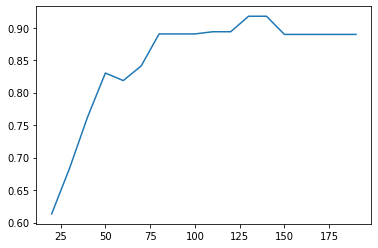

In [ ]:

mfpp = list(range(20,200, 10))

accuracies = []

for i in mfpp:
  # select data 

  X_train_i, y_train_i, X_test_i, y_test_i  = select_and_preprocess_data( i, verbose = False)

  svm = train_svm_classifier(X_train_i, y_train_i)
  
  accuracies += [(test_svm_classifier(svm, X_test_i, y_test_i, verbose = False))]

plt.plot(mfpp, accuracies)
plt.show()


On voit sur le graphique ci-dessous que le paramètre *min_faces_per_person* a un impact net sur la performance du classifieur. Lorsqu'on inclut toutes les classes qui ont plus de 20 images, l'exactitude est de 0.60 ce qui n'est pas exceptionnel. A partir de 50 photos par classes, on arrive à une exactitude de 0.80 ce qui est tout à fait aceptable. Les performances au dessus de 90 sont obtenues lorsqu'on restreint encore plus le nombre de classes, en portant le nombre minimal de photos par classe à plus de 75. Finalement, **la performance du SVM est quasiment proportionnelle au paramètre min_faces_per_person**. Cela n'est pas étonnant car les classificateurs sont plus performants lorsqu'ils doivent opérer sur un petit nombre de classes avec beaucoup d'exemples.

## 3. Impact de la taille de l'ensemble d'entraînement

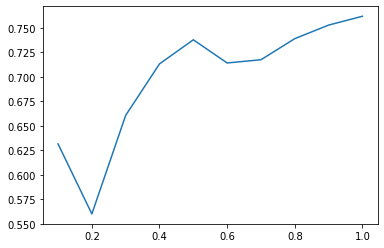

In [ ]:

fraction = [ x * 0.1 for x in range(1,11)]

accuracies = []

for i in fraction:
  # select data 

  X_train_i, y_train_i, X_test_i, y_test_i = select_and_preprocess_data(mfpp=40, fraction=i, verbose = False)

  svm = train_svm_classifier(X_train_i, y_train_i)
  
  accuracies += [(test_svm_classifier(svm, X_test_i, y_test_i, verbose = False))]

plt.plot(fraction, accuracies)
plt.show()

Le graphe ci - dessus montre que **l'exactitude diminue lorsque la taille de l'ensemble d'entraînement diminue** : par exemple en ne gardant que 20% de celui-ci, on perd environ 20 points d'exactitude. 

# Exercice 3 - SVM et ACP



On applique une analyse en composante principale (ACP) aux données. On fait varier le nombre de composantes entre 5 et 150 pour analyser l'exactitude et le temps d'entraînement.

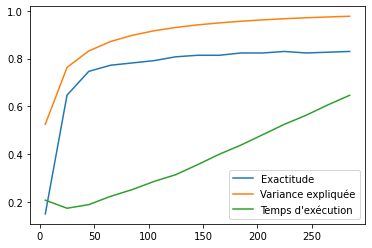

In [ ]:
# selection des données 

min_faces_per_person = 50 
X_scaled, y  = select_and_preprocess_data( min_faces_per_person, test_split = False, verbose = False)

# application de l'APC

accuracies = []
times = []
explained_variances = []


nb_components = [i for i in range( 5,300, 20)]
for n_components in nb_components :

  total_explained_variance_ratio = 0 
  # application de l'APC

  pca = PCA(n_components = n_components)
  X_reduced = pca.fit_transform(X_scaled)
  explained_variance_ratio = pca.explained_variance_ratio_
  total_explained_variance_ratio = np.sum(explained_variance_ratio)
  explained_variances += [total_explained_variance_ratio]

  X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state = 42) # séparation en train et test set 

  # entrainement 
  start_time = time.time()
  svm = train_svm_classifier(X_train, y_train)
  train_time = time.time()
  times += [train_time- start_time] # on enregistre le temps de calcul
  accuracies += [(test_svm_classifier(svm, X_test, y_test, verbose = False))] # on stocke l'exactitude 


ax = plt.subplot()

acc, = ax.plot(nb_components, accuracies)
acc.set_label('Exactitude')

#t, = ax.plot(nb_components,times)
#t.set_label('Temps d'execution)

var, = ax.plot(nb_components, explained_variances)
var.set_label("Variance expliquée")

tim, = ax.plot(nb_components, times)
tim.set_label("Temps d'exécution")

ax.legend()
plt.show()


**Question 1 :**
   Le graphe ci-dessus nous montre que, lorsque le nombre de composantes de l'ACP augmente, l'exactitude du classificateur augmente également. Cela n'est pas étonnant car la variance expliquée augmente avec le nombre de composantes. On observe que l'exactitude atteint un plateau aux alentours entre **100 et 150 composantes**. On en déduit qu'une ACP avec une valeur située dans cet intervalle permet de réduire le coût computationnel tout en conservant un maximum d'exactitude. 

**Question 2 :**

On observe que le temps d'exécution linéairement avec le nombre de composantes. Il est doncavantageux d'appliquer une ACP afin de le réduire : sans APC, le temps d'éxecution moyen pour le même dataset (min_faces_per_person = 50) était d'une dizaine de seconde, avec 150 composantes, il n'est plus que de 0.4 secondes environ.  

**Question 3**

On réitère l'expérience avec les paramètres slice_=None et resize=1 lors du chargement des données. 

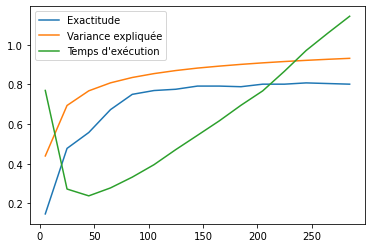

In [ ]:
# selection des données 

min_faces_per_person = 50 
X_scaled, y  = select_and_preprocess_data( min_faces_per_person, test_split = False, verbose = False, special_params = True)

# application de l'APC

accuracies = []
times = []
explained_variances = []


nb_components = [i for i in range( 5,300, 20)]
for n_components in nb_components :

  total_explained_variance_ratio = 0 
  # application de l'APC

  pca = PCA(n_components = n_components)
  X_reduced = pca.fit_transform(X_scaled)
  explained_variance_ratio = pca.explained_variance_ratio_
  total_explained_variance_ratio = np.sum(explained_variance_ratio)
  explained_variances += [total_explained_variance_ratio]

  X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state = 42) # séparation en train et test set 

  # entrainement 
  start_time = time.time()
  svm = train_svm_classifier(X_train, y_train)
  train_time = time.time()
  times += [train_time- start_time] # on enregistre le temps de calcul
  accuracies += [(test_svm_classifier(svm, X_test, y_test, verbose = False))] # on stocke l'exactitude 


ax = plt.subplot()

acc, = ax.plot(nb_components, accuracies)
acc.set_label('Exactitude')

#t, = ax.plot(nb_components,times)
#t.set_label('Temps d'execution)

var, = ax.plot(nb_components, explained_variances)
var.set_label("Variance expliquée")

tim, = ax.plot(nb_components, times)
tim.set_label("Temps d'exécution")

ax.legend()
plt.show()


* Lorsqu'on passe le paramètre *slice = None*, le dataset est composé des photos entières et non plus de la partie "intéressante", celle du visage de la personne. 
* Le paramètre resize permet de réduire la taille des images. Avec *resize = 1*, la taille des image augmente par rapport au paramètre par défaut qui est 0.5.

Le graphe ci-dessus nous montre que le temps d'exécution augmente avec ces paramètres, en moyenne il double ce qui est cohérent avec l'augmentation de la taille liée au *resize*. De plus, le pourcentage de variance expliquée par les composantes diminue, de même que l'exactitude : c'est lié au paramètre *slice* : en effet, chaque photo contient désormais une plus grande part de pixels de backgrounds qui ne sont pas utiles pour la classification. 


# Exercice 4



## Naive Bayes
On essaie de résoudre le problème en utilisant un classificateur Naive Bayes. Il s'agit d'un algorithme assez simple qui ne nécéssite pas d'optimisation d'hyperparamètres.


In [ ]:
from sklearn.naive_bayes import GaussianNB

# on charge les données 
mfpp = 50
dataset = fetch_lfw_people(min_faces_per_person = mfpp)
X = dataset.data
y = dataset.target

targets= dataset.target_names
n_classes = targets.shape[0]

# selection d'une fraction de dataset 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

gnb = GaussianNB()



# entraînement 


gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

g_precision, g_recall, g_f_score, _ = [mean(x) for x in precision_recall_fscore_support(y_test, y_pred)]

print("Precision : %s, Recall : %s, F-score : %s" %( g_precision, g_recall, g_f_score))


Precision : 0.3507466286029542, Recall : 0.42360092918504133, F-score : 0.32251571393791645


Les scores obtenus avec le Naive Bayes sont très faibles :  un f-score de seulement 0.3 en moyenne. On en déduit qu'il ne s'agit pas d'une méthode adaptée pour traiter le problème. 

## SVM à Noyau Polynomial 
Dans les exercices 2 et 3, nous utilisions un SVM à noyau linéaire. Ici, nous testons deux autres types de SVMs : à noyau polynomial et rbf, qui diffèrent donc par la forme de la fonction de noyau qu'ils utilisent.



In [ ]:
# On charge les données grace à la fonction adaptée aux svm 
mfpp = 50 

X_scaled, y = select_and_preprocess_data(mfpp, verbose = False, test_split=False)

# on applique l'APC pour réduire le temps de calcul 

pca = PCA(n_components = 100)
X_reduced = pca.fit_transform(X_scaled)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state = 42)



In [ ]:

# estimation des paramètres 


p_grid = {"C": [1, 10, 100, 1000],
          "gamma": [0.0001, 0.001, .01, .1]}


poly_svm = SVC(kernel = 'poly')
rbf_svm = SVC(kernel = 'rbf')

NUM_TRIALS = 3


poly_scores = np.zeros(NUM_TRIALS)
rbf_scores = np.zeros(NUM_TRIALS)


#for i in range(NUM_TRIALS):
    #cv = KFold(n_splits=4, shuffle=True, random_state=i)
poly_clf = GridSearchCV(estimator=poly_svm, param_grid=p_grid)
rbf_clf = GridSearchCV(estimator=rbf_svm, param_grid=p_grid)
poly_clf.fit(X_train_pca, y_train)
rbf_clf.fit(X_train_pca, y_train)
    #print(i)

print("Best parameters for polynomial kernel : ", poly_clf.best_estimator_)
print()

print("Best parameters for rbf kernel : ", rbf_clf.best_estimator_)

Best parameters for polynomial kernel :  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best parameters for rbf kernel :  SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
# entraînement

poly_svm = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly')

rbf_svm = SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf')

poly_y_pred = poly_svm.fit(X_train_pca, y_train).predict(X_test_pca)
rbf_y_pred = rbf_svm.fit(X_train_pca, y_train).predict(X_test_pca)

poly_precision, poly_recall, poly_f_score, _ = [ mean(x) for x in precision_recall_fscore_support(y_test, poly_y_pred)]
rbf_precision, rbf_recall, rbf_f_score, _ =  [mean(x) for x in precision_recall_fscore_support(y_test, rbf_y_pred)]


## Comparaison entre modèles

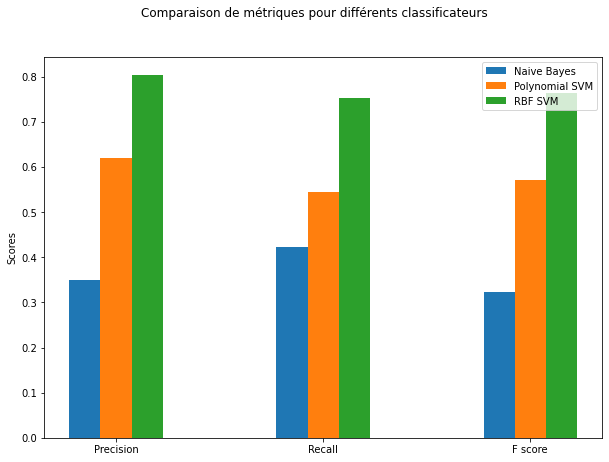

In [ ]:
# bar charts pour comparer les performances des modèles sur les différentes classes 

fig, axs = plt.subplots( figsize=(10, 7))
fig.suptitle('Comparaison de métriques pour différents classificateurs')

#x = list(range(targets.shape[0]))
x = [0, 1, 2]
width = 0.15


# Precision

gaussian = axs.bar([a - width for a in x], [g_precision, g_recall, g_f_score], width, label='Naive Bayes')
poly = axs.bar([a for a in x], [poly_precision, poly_recall, poly_f_score], width, label='Polynomial SVM')
rbf= axs.bar([a + width for a in x], [rbf_precision, rbf_recall, rbf_f_score], width, label='RBF SVM')

axs.set_ylabel('Scores')
axs.set_xticks(x)
axs.set_xticklabels(["Precision", "Recall", "F score"])
axs.legend()




plt.show()

Ces résultats nous montrent que le classificateur SVM à noyau RBF est de loin le plus performant des trois sur ce problème.

## Méthodes basées sur les arbres de décision
1. Decision Trees
2. Random Forests
3. Boosted Trees


In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [ ]:
# selection des données 

min_faces_per_person = 50 
X_scaled, y  = select_and_preprocess_data( min_faces_per_person, test_split = False, verbose = False, special_params = False)

"""
Remarque : select_preprocess_data met les données à l'échelle, ce qui n'est pas nécessaire pour les méthodes basées sur les arbres.
"""

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size = 0.8, random_state = 42)

###Decision Tree Classifier


In [ ]:
p_grid = {
    "max_depth":[10,100,1000,10000],
    "min_samples_leaf":[1, 20, 50, 100]
}

dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, p_grid)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)

print("Best params for DecisionTree : ", clf.best_params_)

Best params for DecisionTree :  {'max_depth': 10000, 'min_samples_leaf': 20}


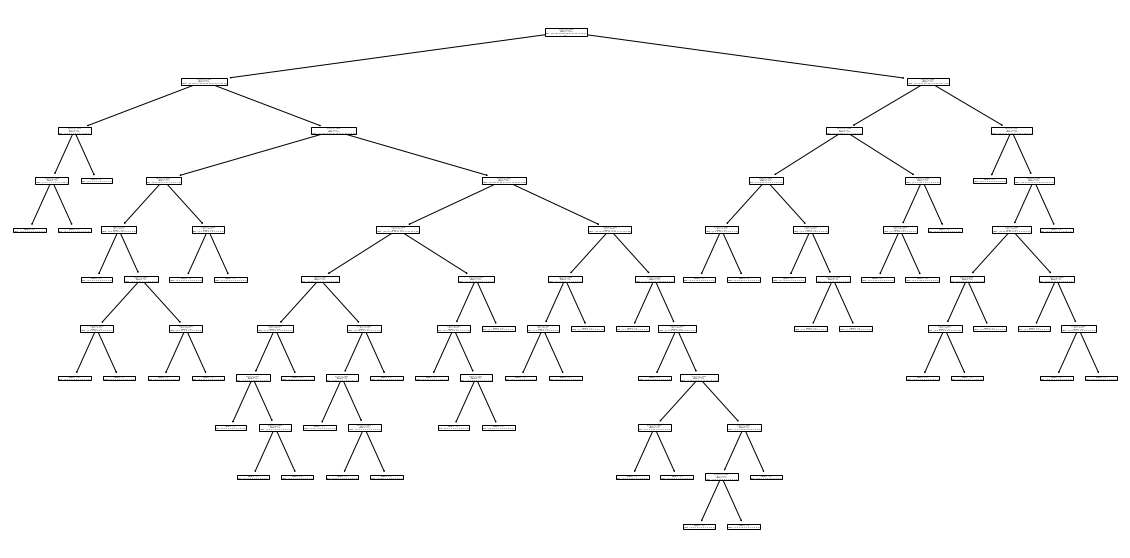

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf.best_estimator_)
plt.show()

### Random Forest


In [ ]:
p_grid = {
    "n_estimators" : [10, 100, 1000],
    "max_features" : ["sqrt", "log2"]
}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, p_grid)

clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

print("Best parameters for Random Forest :", clf.best_params_)

Best parameters for Random Forest : {'max_features': 'sqrt', 'n_estimators': 1000}


In [ ]:
import plotly.express as px

img_importance = clf.best_estimator_.feature_importances_
print(img_importance)

img_importance = img_importance.reshape((62,47))

print(img_importance.shape)

fig = px.imshow(img_importance, title="Feature importance par pixel")
fig.show()

[0.00151002 0.00160273 0.00104364 ... 0.00028092 0.00024282 0.00021778]
(62, 47)


La _feature importance_ permet ici de connaître les pixels les plus influents dans l'ajustement du classificateur. Ici, on voit que la forêt aléatoire perçoit bien les contours de visages et les zones des yeux. Néanmoins, elle s'attache également à des détails de fond (en haut à gauche et à droite), ce qui n'est pas forcément souhaitable.


### Extremely Randomized Trees


In [ ]:
p_grid = {
    "n_estimators": [10,100, 1000],
    "max_features" : ['sqrt', 'log2']
}

xt = ExtraTreesClassifier()
clf = GridSearchCV(xt, p_grid)
clf.fit(X_train, y_train)
y_pred_xt = clf.predict(X_test)

print("Best params for Extra Trees :", clf.best_params_)

Best params for Extra Trees : {'max_features': 'sqrt', 'n_estimators': 1000}


In [ ]:
img_importance = clf.best_estimator_.feature_importances_
print(img_importance)

img_importance = img_importance.reshape((62,47))

print(img_importance.shape)

fig = px.imshow(img_importance, title = "Feature importance par pixel")
fig.show()

[0.00106279 0.00096191 0.00080914 ... 0.00031913 0.00031526 0.00032817]
(62, 47)


### Gradient boosting tree


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

p_grid = {
    "loss" : ['deviance'],
    "n_estimators" : [100],
    "learning_rate" : [1, 0.1, 0.01]
}

gbt = GradientBoostingClassifier()
clf = GridSearchCV(gbt, p_grid)

clf.fit(X_train, y_train)
y_pred_gbt = clf.predict(X_test)

print('Best parameters for Gradient Boosting Trees :', clf.best_params_)

## Comparaison des classificateurs basés sur les arbres




On voit ici que les méthodes basées sur les arbres donnent plutôt des performances équivalentes aux SVM à noyau linéaire/polynômial, mais loin derrière la SVM à noyaux RBF.

En effet, l'arbre de décision classique s'avère être un mauvais décideur, car il n'est pas capable de donner une importance particulière à certaines zones du visage (il se contente naïvement de construire des noeuds sans information sur le positionnement du pixel). 

Les méthodes de Bagging (RandomForest et Extra Trees) ont elles l'avantage de pouvoir construire un ordre d'importance sur les différents pixels, ce qui permet, (grâce à l'entraînement d'un ensemble d'arbres) de classer selon les parties intéressantes des visages. 

Néanmoins, elles ne peuvent pas rivaliser avec la SVM à noyau RBF, car elles sont incapables de construire des séparations de l'espaces continues et courbes **(pas de détection aisée de contours)**.



In [ ]:
from  statistics import mean

dt_precision, dt_recall, dt_f_score, _ = [ mean(x) for x in precision_recall_fscore_support(y_test, y_pred_tree)]
rf_precision, rf_recall, rf_f_score, _ = [ mean(x) for x in precision_recall_fscore_support(y_test, y_pred_rf)]
xt_precision, xt_recall, xt_f_score, _ = [ mean(x) for x in precision_recall_fscore_support(y_test, y_pred_xt)]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



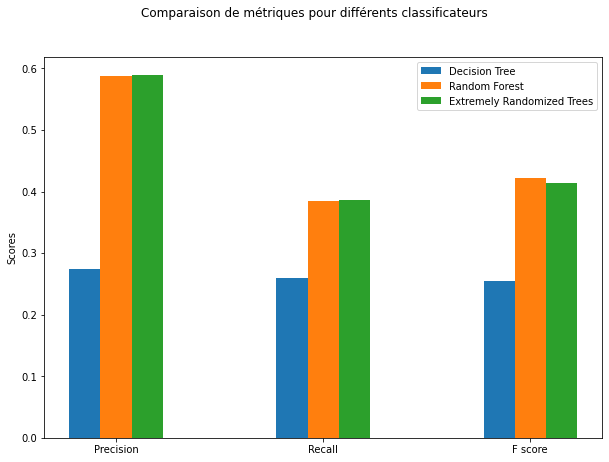

In [ ]:
# bar charts pour comparer les performances des modèles sur les différentes classes 

fig, axs = plt.subplots( figsize=(10, 7))
fig.suptitle('Comparaison de métriques pour différents classificateurs')

#x = list(range(targets.shape[0]))
x = [0, 1, 2]
width = 0.15


# Precision

dt = axs.bar([a - width for a in x], [dt_precision, dt_recall, dt_f_score], width, label='Decision Tree')
rf = axs.bar([a for a in x], [rf_precision, rf_recall, rf_f_score], width, label='Random Forest')
xt= axs.bar([a + width for a in x], [xt_precision, xt_recall, xt_f_score], width, label='Extremely Randomized Trees')

axs.set_ylabel('Scores')
axs.set_xticks(x)
axs.set_xticklabels(["Precision", "Recall", "F score"])
axs.legend()

plt.show()